In [354]:
#Code Prototype for 1D use on EXCLAIM Project with two sensors of different data rates. Predictions are made in between measurements (interpolated), not with them. Code by Joaquin Matticoli

In [355]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
#from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
#import filterpy.stats as stats
import math
from math import sqrt
import decimal
from decimal import *

In [356]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(t, predict, update, z1, z2, K): #Everything
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '    {:.3f}    {:.3f}     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z1, z2, update[0], update[1], K))
    
def print_gh1(t, predict, update, z1, K): #Sensor 1 and prediction
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '    {:.3f}    -----     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z1, update[0], update[1], K))
    
def print_gh2(t, predict, update, z2, K): #Sensor 2 and prediction
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '    -----    {:.3f}     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z2, update[0], update[1], K))
    
def print_gh3(t, predict): #Prediction only
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '    ------   ------     -----    -----    -----'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format())
    
def print_gh4(t, update, z1, z2): #Sensor 1 and Sensor 2 only
    predict_template = '{:.3f}    ------    ------'
    update_template = '   {:.3f}    {:.3f}     {:.3f}     {:.3f}    -----'
    
    print(predict_template.format(t),end=' ')
    print(update_template.format(z1, z2, update[0], update[1]))
    
def print_gh5(t, update, z1): #Sensor 1 only
    predict_template = '{:.3f}    -----    ------'
    update_template = '    {:.3f}    -----     {:.3f}     {:.3f}    -----'

    print(predict_template.format(t),end=' ')
    print(update_template.format(z1, update[0], update[1]))
    
def print_gh6(t, update, z2): #Sensor 2 only
    predict_template = '{:.3f}    -----    ------'
    update_template = '   -----    {:.3f}     {:.3f}     {:.3f}    -----'

    print(predict_template.format(t),end=' ')
    print(update_template.format(z2, update[0], update[1]))

In [357]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt #+ (torque/I)*dt**2

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + randn()*self.meas1_std
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in deg/sec."""
        measurement2 = self.angular_velocity + randn()*self.meas2_std
        return measurement2

    def move_and_sense(self, dt=1.0):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move(dt=dt)
        return self.sense_position()

In [358]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor1_var = 0.15 # variance in the position sensor
sensor2_var = 0.3 # variance in the velocity sensor use actual sensor info
x = gaussian(0., 50.)  # payload's initial orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
spectral_density = 0.8 #Spectral density of the measurement noise
dt1 = 0.3 # data rate of sensor in seconds
dt2 = 0.7 # time step in seconds for second sensor
dtp = 0.2 # time step in between predictions, must be smaller or equal to dt of sensor(s)
total_time = 6. # Total time passed from beginning to end of experiment
t = 0. #initial time in seconds
torque = 5 #N*m

#-----------USER INPUT ENDS--------------------------------

I = 3900 # Moment of inertia around azimuth for mission in kg * m^2
dt = dtp #initialize dt, will be modified constantly in later equations
process_model = gaussian(angular_velocity, process_var) # displacement to add to x
smallest_time = min(dt1, dt2, dtp) #The smaller time increment NOTE: THIS CODE ONLY WORKS IF dtp IS SMALLEST
n_iterp = math.floor(total_time/smallest_time) # Number of predictions
n_iter = math.floor(total_time/dt1)+1 # Number of measurements that the sensor will take
t_0 = t

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var,
    measurement2_var=sensor2_var,
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided

def remain(x1, x2): #produces correct remainder, % function does not work properly for decimals
    w = Decimal(str(x1))
    q = Decimal(str(x2))
    ans =  w % q
    return float(ans)

zs, zs2, ztrue = [], [], []
t_old2 = t_0
while t <= total_time:
    t = round(t,1)
    dt3 = t - t_old2
    r1 = remain(t, dt1)
    r2 = remain(t, dt2)
#     print(t)
    if r1 == 0. and r2 == 0.: #takes measurment of both sensors but only moves once
        zs.append(payload.move_and_sense(dt=dt3))
        zs2.append(payload.sense_velocity())
#         print('Here12 Time is: %.2f' % t) #check
    elif r1 == 0.: #Sensor 1 is taking a measurement
        zs.append(payload.move_and_sense(dt=dt3))
#         print('Here1 Time is: %.2f' % t) #check
    elif r2 == 0.: #Sensor 2 is taking a measurement
        zs2.append(payload.sense_velocity())
#         print('Here2 Time is: %.2f ' % t, 'r2 = %.2f' % r2) #check
    else:
        print('Error: t = %.2f' % t) # check
    ztrue.append(payload.x)
    t_old2 = t
    t = round((t + min(dt1,dt2)),1)
#     print(t)
    if (remain(t,dt1) < min(dt1,dt2) and remain(t,dt1) != 0 and remain(t,dt2) < min(dt1,dt2) and remain(t,dt2) != 0):
        t = t - min(remain(t,dt1),remain(t,dt2))
#         print('First, t = %.2f' % t)
    elif(remain(t,dt1) < min(dt1,dt2) and remain(t,dt1) != 0):
        t = t - remain(t,dt1)
#         print('Second, t = %.2f' % t)
    elif(remain(t,dt2) < min(dt1,dt2) and remain(t,dt2) != 0):
        t = t - remain(t,dt2)
#         print('Third, t = %.2f' % t)
    
finalposition = payload.x

PREDICT                           UPDATE
  t        x       var         z1       z2         x       var       K
0.000    0.000    50.002     -0.298    0.327     -0.297     0.150    0.000
0.200    -0.233    0.164     ------   ------     -----    -----    -----
0.300    -----    ------     1.221    -----     0.526     0.078    -----
0.400    0.586    0.090     ------   ------     -----    -----    -----
0.600    0.706    0.146     4.163    -----     2.411     0.074    0.493
0.700    -----    ------    -----    0.662     2.180     0.064    -----
0.800    2.317    0.074     ------   ------     -----    -----    -----
0.900    -----    ------     5.756    -----     3.454     0.050    -----
1.000    3.671    0.062     ------   ------     -----    -----    -----
1.200    4.103    0.113     7.571    -----     5.591     0.064    0.429
1.400    6.478    0.128     -----    1.027     5.775     0.085    0.206
1.500    -----    ------     6.755    -----     6.129     0.054    -----
1.600    6.358   

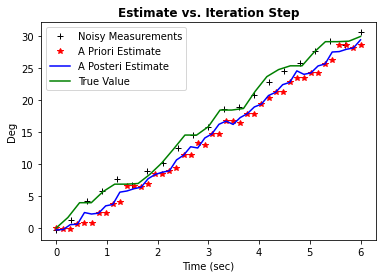

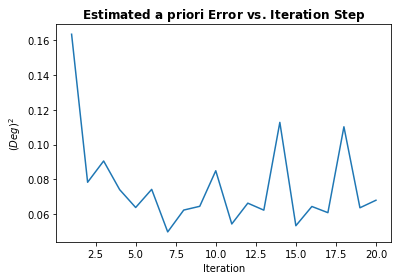

In [359]:
def plotstuff():
    plt.figure()
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Noisy Measurements')
    plt.plot(np.linspace(0,total_time,len(x1)),x1,'r*',label='A Priori Estimate')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteri Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Deg')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[1:n_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Deg)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

x1 = [] #Prediction before update / with no update
Phat = [] #Variance after update
xhat = [] #Estimate after update
counter = 0
if printcase == 1:
    print('PREDICT                           UPDATE')
    print('  t        x       var         z1       z2         x       var       K')

# perform Kalman filter on measurements zs1 and zs2
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[1., 1.], [0., 1.]]) #Use this or A?????
f.x = np.array([[x.mean], [angular_velocity*smallest_time]]) #??
f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                 [(dt**2)/2,  dt      ]]) *spectral_density
f.P = np.diag([x.var,process_var]) #Variance
f.B = np.array([[0],[1/I]])
f.u = torque

counter1 = 0
counter2 = 0
t = t_0
t_old = t_0
check = 0
check2 = 0
# print('dt1 = %.2f ' % dt1, 'dt2 = %.2f ' % dt2, 'dtp = %.2f' % dtp)
while t <= total_time:
    t = round(t,1)
    r1 = remain(t, dt1)
    r2 = remain(t, dt2)
    r3 = remain(t, dtp)
#     print()
#     print('t = %.2f ' % t, 'r1 = %.2f ' % r1, 'r2 = %.2f ' % r2, 'r3 = %.2f ' % r3)
    if r1 == 0. and r2 == 0. and r3 == 0.: #Sensor 1, Sensor 2, and prediction
        dt = t - t_old
        f.F[0,1] = dt
        f.predict()
        f.R[0,0] = sensor1_var
        f.H = np.array([[1., 0.]])
        f.update(zs[counter1])
        f.R[0,0] = sensor2_var
        f.H = np.array([[0., 1.]])
        f.update(zs2[counter2])
#         print('time: %.2f ' % t, 'r1 = %.2f ' % r1, 'r2 = %.2f ' % r2, 'r3 = %.2f ' % r3)
#         print('Everything')
        t_old = t
        t = t + smallest_time
        t = round(t,1)
        prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh(t_old, prior, x, zs[counter1], zs2[counter2], f.K[0,0])
        counter1 = counter1 + 1
        counter2 = counter2 + 1
    elif r1 == 0. and r2 == 0.: #Sensor 1 and Sensor 2
        dt = t - t_old
        f.F[0,1] = dt
        f.R[0,0] = sensor1_var
        f.H = np.array([[1., 0.]])
        f.update(zs[counter1])
        f.R[0,0] = sensor2_var
        f.H = np.array([[0., 1.]])
        f.update(zs2[counter2])
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2)
#         print('Sensor 1 and Sensor 2')
        t_old = t
        t = t + smallest_time
        t = round(t,1)
        prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh4(t_old, x, zs[counter1], zs2[counter2])
        counter1 = counter1 + 1
        counter2 = counter2 + 1
    elif r1 == 0: # < smallest_time and check == 0
        check = 1
        f.H = np.array([[1., 0.]])
        if r3 == 0: #Sensor 1 and prediction
            dt = t - t_old
            f.F[0,1] = dt
            f.R[0,0] = sensor1_var
            f.predict()
            f.update(zs[counter1])
#             print('time: %.2f ' % t, 'r1 = %.2f ' % r1, 'r3 = %.2f' % r3)
#             print('Sensor 1 and prediction')
            t_old = t
            t = t + smallest_time
            t = round(t,1)
            prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
            x = gaussian(f.x[0,0], f.P[0,0])   
            if printcase == 1:
                print_gh1(t_old, prior, x, zs[counter1], f.K[0,0])
            counter1 = counter1 + 1
        else: #Sensor 1 only
            dt = t - t_old
            f.F[0,1] = dt
            f.R[0,0] = sensor1_var
            f.update(zs[counter1])
#             print('time: %.2f ' % t, 'r1 = %.2f' % r1)
#             print('Sensor 1 only')
            t_old = t
            t = t + smallest_time
            t = round(t,1)
            prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
            x = gaussian(f.x[0,0], f.P[0,0])   
            if printcase == 1:
                print_gh5(t_old, x, zs[counter1])
            counter1 = counter1 + 1
    elif r2 == 0: # < smallest_time and check2 == 0
        check2 = 1
        f.H = np.array([[0., 1.]])
        if r3 == 0: #Sensor 2 and prediction
            dt = t - t_old
            f.F[0,1] = dt
            f.R[0,0] = sensor2_var
            f.predict()
            f.update(zs2[counter2])
#             print('time: %.2f ' % t, 'r2 = %.2f ' % r2, 'r3 = %.2f' % r3)
#             print('Sensor 2 and prediction')
            t_old = t
            t = t + smallest_time
            t = round(t,1)
            prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
            x = gaussian(f.x[0,0], f.P[0,0])   
            if printcase == 1:
                print_gh2(t_old, prior, x, zs2[counter2], f.K[0,0])
            counter2 = counter2 + 1
        else: #Sensor 2 only
            dt = t - t_old
            f.F[0,1] = dt
            f.R[0,0] = sensor2_var
            f.update(zs2[counter2])
#             print('time: %.2f ' % t, 'r2 = %.2f' % r2)
#             print('Sensor 2 only')
            t_old = t
            t = t + smallest_time
            t = round(t,1)
            prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
            x = gaussian(f.x[0,0], f.P[0,0])   
            if printcase == 1:
                print_gh6(t_old, x, zs2[counter2])
            counter2 = counter2 + 1
    else: #Prediction only
        dt = t - t_old
        f.F[0,1] = dt
        f.predict()
#         print('time: %.2f ' % t, 'r3 = %.2f' % r3)
#         print('Prediction only')
        t_old = t
        t = t + smallest_time
        t = round(t,1)
        prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh3(t_old, prior)
#     print(t)
    if (remain(t,dt1) < smallest_time and remain(t,dt1) != 0 and remain(t,dt2) < smallest_time and remain(t,dt2) != 0):
        t = t - min(remain(t,dt1),remain(t,dt2))
#         print('Check0')
    elif(remain(t,dt1) < smallest_time and remain(t,dt1) != 0 and check == 0):
        t = t - remain(t,dt1)
#         print('Check1')
    elif(remain(t,dt2) < smallest_time and remain(t,dt2) != 0 and check2 == 0):
        t = t - remain(t,dt2)
#         print('Check2')
    elif(remain(t,dtp) < smallest_time and remain(t,dtp) != 0):
        t = t - remain(t,dtp)
#         print('Check3')
    check = 0
    check2 = 0
    if plotcase == 1:
        x1.append(prior.mean)
        xhat.append(x.mean)
        Phat.append(x.var)

if printcase == 1:
    print()
    print('Final estimate:           {:10.3f}'.format(x.mean))
    print('Actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()